In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_access as mdb

# Personal modules
import TUutils
import plots
from models import VAE

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# First Section
The first section of this notebook does the selection of the variables that are going to be used in the model. I am going to check whether the amount of missing values on each and the final dimensionality of the dataset. 

In [3]:
# Listing the tables on the database and opening the session dataset
db_filename = './1975/TU1975.mdb'

# Listing the tables.
for tbl in mdb.list_tables(db_filename):
  print(tbl)

# Read a small table.
df = mdb.read_table(db_filename, 'dataset_session')

dataset_bil
dataset_household
dataset_journey
dataset_session
dataset_tur
enumvalues75


In [4]:
# Create RespHasBicycle from TotalBicLen 
# Primary occupation code is non-existent on the session dataset but it MIGHT (not for sure) be inferred from the tur dataset
# IncRespondendt is not on the session dataset
# RespHasSeasonTicket not on the session dataset
# WorkHoursPw not existent on the session dataset

In [5]:
# These are the variables we are intereste in modeling. Other interesting variables we would like to model are not available in the dataset
vars_interest = [
"""RespSex
RespAgeSimple
RespMainOccup
IncFamily2000
FamNumPers
FamNumAdults
HomeAdrMunCode
RespHasBicycle
HousehCarOwnership
TotalBicLen
"""]

In [6]:
vars_interest = vars_interest[0].splitlines()

In [7]:
vars_interest

['RespSex',
 'RespAgeSimple',
 'RespMainOccup',
 'IncFamily2000',
 'FamNumPers',
 'FamNumAdults',
 'HomeAdrMunCode',
 'RespHasBicycle',
 'HousehCarOwnership',
 'TotalBicLen']

In [8]:
df = df[vars_interest].astype('float')
df['RespHasBicycle'] = np.where(df['TotalBicLen']==0., 1, 0)
df['Kids'] = df.FamNumPers-df.FamNumAdults
df['Kids'] = np.where(df['Kids']>0., 1, 0)
df.drop(columns=['TotalBicLen', 'FamNumPers', 'FamNumAdults'], inplace=True)
df.dropna(inplace=True)

In [33]:
BINNING=True
numerical = ['RespAgeSimple', 'IncFamily2000']
train, test, validation, pre_one_hot_df, one_hot_df, col_names = TUutils.data_creator(df, numerical=numerical, train_prop=0.8, val_prop=0.4, binning=True, condition_on=None)

Train shape is: (2877, 104)
Validation shape is: (1918, 104)
Test shape is: (1199, 104)


In [38]:
# Re-Definition of global lists for numerical and categorical variables. This is only ran iff we binned the numerical variables 
if BINNING: 
    numerical = []
    numerical_col_n = len(numerical) # Number of numerical variable

    categorical = [col for col in list(pre_one_hot_df) if col not in numerical]
    pre_one_hot_df[categorical] = pre_one_hot_df[categorical].astype('category')
    categorical_col_n = len(categorical) # Number of categorical variables
    categories_n = [] # Number of categories in each categorical variable
    for cat in categorical:
        categories_n.append(len(pre_one_hot_df[cat].cat.categories)) 
    categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
    categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
    categories_cum = [0] + categories_cum

In [39]:
vae_1975 = VAE(train=train, validation=validation, numerical_col_n=numerical_col_n, categorical_col_n=categorical_col_n, categories_n=categories_n, categories_cum=categories_cum, 
            eval_set=['HomeAdrMunCode', 'RespMainOccup', 'IncFamily2000'], # Data
            intermediate_dim=1024, latent_dim=50, n_hidden_layers=1, drop_rate=0.25,# Architecture
            cat_loss_weight=None, beta=0.0025, # Loss
            batch_size=137, epochs=200, learn_rate=0.0005)

#vae_1975 = VAE(train=train, validation=validation, numerical_col_n=numerical_col_n, categorical_col_n=categorical_col_n, categories_n=categories_n, categories_cum=categories_cum, 
#            eval_set=['HomeAdrMunCode', 'RespMainOccup', 'IncFamily2000'], # Data
#            intermediate_dim=1024, latent_dim=100, n_hidden_layers=1, drop_rate=0.1,# Architecture
#            cat_loss_weight=None, beta=0.0025, # Loss
#            batch_size=107, epochs=200, learn_rate=0.0005)

In [40]:
vae_1975.vae_fit()

Train on 2877 samples, validate on 1918 samples
Epoch 1/200
 - 2s - loss: 22.9179 - val_loss: 15.4875
Epoch 2/200
 - 0s - loss: 18.5942 - val_loss: 13.9169
Epoch 3/200
 - 0s - loss: 17.1285 - val_loss: 12.9752
Epoch 4/200
 - 0s - loss: 16.0400 - val_loss: 12.3029
Epoch 5/200
 - 0s - loss: 15.2439 - val_loss: 11.8114
Epoch 6/200
 - 0s - loss: 14.4243 - val_loss: 11.4131
Epoch 7/200
 - 0s - loss: 13.9106 - val_loss: 11.0625
Epoch 8/200
 - 0s - loss: 13.3619 - val_loss: 10.7485
Epoch 9/200
 - 0s - loss: 12.8287 - val_loss: 10.4424
Epoch 10/200
 - 0s - loss: 12.3954 - val_loss: 10.2083
Epoch 11/200
 - 0s - loss: 11.9571 - val_loss: 9.9420
Epoch 12/200
 - 0s - loss: 11.6541 - val_loss: 9.7986
Epoch 13/200
 - 0s - loss: 11.3874 - val_loss: 9.5775
Epoch 14/200
 - 0s - loss: 11.1311 - val_loss: 9.4954
Epoch 15/200
 - 0s - loss: 10.8096 - val_loss: 9.3052
Epoch 16/200
 - 0s - loss: 10.5533 - val_loss: 9.1998
Epoch 17/200
 - 0s - loss: 10.4139 - val_loss: 9.1199
Epoch 18/200
 - 0s - loss: 10.203

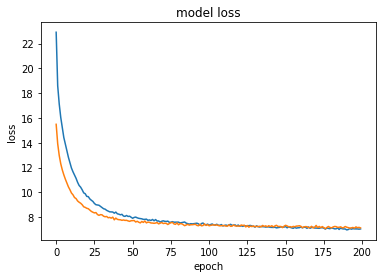

In [41]:
plt.plot(vae_1975.history.history['loss'])
plt.plot(vae_1975.history.history['val_loss'])
#plt.plot(prueba_VAE.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [53]:
vae_1975.n_samples = 30000 # Set the number of samples
categorical = ['HomeAdrMunCode', 'RespMainOccup', 'IncFamily2000']
#categorical = ['RespSex', 'RespAgeSimple', 'RespMainOccup']


agg_vars = categorical

##### Returning to original format
test_df = TUutils.samples_to_df(test.transpose(), print_duplicates=False, col_names=col_names, original_df=df, pre_one_hot_df=pre_one_hot_df)
#if municipality_number is not None: # Testing for a smaller subset of data
#    test_df = test_df[test_df.MunicipalityOrigin==municipality_number]

train_df = TUutils.samples_to_df(train.transpose(), print_duplicates=False, col_names=col_names, original_df=df, pre_one_hot_df=pre_one_hot_df)
#if municipality_number is not None: # Testing for a smaller subset of data
#    train_df = train_df[train_df.MunicipalityOrigin==municipality_number]

samples = vae_1975.sampler()
vae_df = TUutils.samples_to_df(samples, print_duplicates=False, col_names=col_names, original_df=df, pre_one_hot_df=pre_one_hot_df)
#if municipality_number is not None: # Testing for a smaller subset of data
#    vae_df = vae_df[vae_df.MunicipalityOrigin==municipality_number]
#    print(len(vae_df))

#random_df = random_sampler(len(test_df), categorical)
#margin_df = margin_sampler(len(test_df), categorical)

##### Count creator
#random_df['count'] = 1
#random_df = random_df.groupby(agg_vars, observed=True).count()/len(random_df)
#random_df /= random_df['count'].sum()

#margin_df['count'] = 1
#margin_df = margin_df.groupby(agg_vars, observed=True).count()/len(margin_df)
#margin_df /= margin_df['count'].sum()

train_df['count'] = 1
train_df = train_df.groupby(agg_vars, observed=True).count()/len(train_df)
train_df /= train_df['count'].sum()

test_df['count'] = 1
test_df = test_df.groupby(agg_vars, observed=True).count()
test_df /= test_df['count'].sum()

vae_df['count'] = 1
vae_df = vae_df.groupby(agg_vars, observed=True).count()
vae_df /= vae_df['count'].sum()

##### Merge and difference
real_and_sampled = pd.merge(test_df, train_df, suffixes=['_real', '_sampled'], on=categorical, how='outer', indicator=True)
real_and_sampled = real_and_sampled[['count_real', 'count_sampled']].fillna(0)
real_and_sampled['diff'] = real_and_sampled.count_real-real_and_sampled.count_sampled
diff = np.array(real_and_sampled['diff'])

metrics = {}
metrics['MAE'] = np.mean(abs(diff))
metrics['MSE'] = np.mean(diff**2)
metrics['RMSE'] = np.sqrt(np.mean(diff**2))
metrics['SRMSE'] = metrics['RMSE']/real_and_sampled['count_real'].mean()
print('MAE:{}, MSE:{}, RMSE:{}, SRMSE:{}'.format(metrics['MAE'], metrics['MSE'], metrics['RMSE'], metrics['SRMSE']))

MAE:0.0006649117368684948, MSE:7.519031167661807e-07, RMSE:0.0008671234726186235, SRMSE:1.4324879767659664


corr = 0.622535
MAE = 0.000665
RMSE = 0.000867
SRMSE = 1.432488
r2 = 0.357840


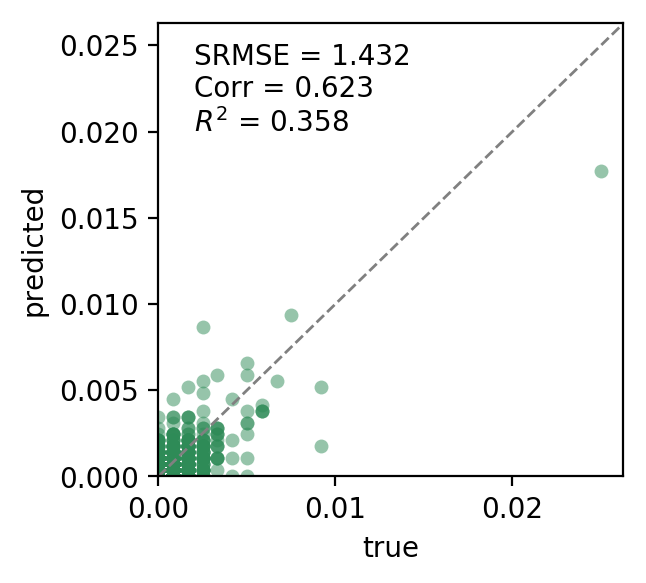

{'mae': 0.0006649117368684948,
 'rmse': 0.0008671234726186242,
 'r2': 0.3578397303597687,
 'srmse': 1.4324879767659675,
 'corr': 0.6225352847940157}

In [54]:
plots.compute_stat(real_and_sampled['count_real'], real_and_sampled['count_sampled'], do_plot=True, plot_log=False)#, plot_name='_'.join(['VAE']+agg_vars))

In [ ]:
MAE:0.0017146418195770545, MSE:8.878247360869242e-06, RMSE:0.00297963879704726, SRMSE:0.45290509715118354 TRAIN
MAE:0.0018685947963467341, MSE:1.1909144488949689e-05, RMSE:0.0034509628350577306, SRMSE:0.7419570095374121 VAE

MAE:0.000586517601419282, MSE:5.52493891778056e-07, RMSE:0.0007432993285198474, SRMSE:1.2836779403537766 TRAIN
MAE:0.00036611735963482713, MSE:3.5299798405980634e-07, RMSE:0.0005941363345729719, SRMSE:1.5703023322763645 VAE